In [1]:
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np
from PIL import Image
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.utils import make_image_grid
from datasets import load_dataset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from tqdm import tqdm
torch.manual_seed(42069)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


'cpu'

In [2]:
DATA_DIR = '../data/data0/lsun/bedroom'

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "../models/ddpm/size128_lr4"  # the model name locally and on the HF Hub

    # push_to_hub = True  # whether to upload the saved model to the HF Hub
    # hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    # hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 69420


config = TrainingConfig()

🤗  https://huggingface.co/docs/diffusers/en/tutorials/basic_training

In [4]:
import torch
import torchvision.transforms.v2 as v2

image_size = 128

preprocess = v2.Compose([
    v2.Resize((config.image_size, config.image_size)),  # Resize to the target size
    v2.PILToTensor(),                     # Convert to tensor with values in range [0, 255]
    v2.ToDtype(torch.float32),            # Ensure the tensor is of type float32
    v2.Lambda(lambda x: x / 255),         # Scale values to [0, 1]
    v2.Normalize([0.5], [0.5])            # Normalize to [-1, 1]
])

In [5]:
dataset = load_dataset(
    '../data/data0/lsun/bedroom',
    data_dir='../data/data0/lsun/bedroom/0',
    split='train_subset',
    trust_remote_code=True,
)
real_img = dataset[0]['image']

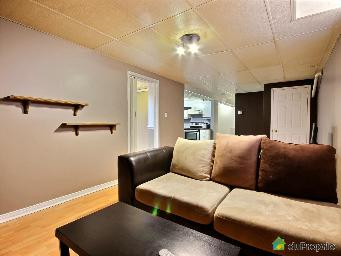

In [6]:
dataset[0]['image']

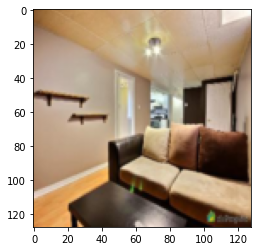

In [7]:
dataset.set_transform(preprocess)
sample_image = dataset[0]['image']
plt.imshow((sample_image.permute(1, 2, 0)+1)/2)

In [8]:
def get_unetmodel():
    model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)
    return model

model = get_unetmodel()


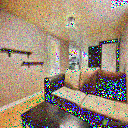

In [9]:
sample_image = dataset[0]["image"].unsqueeze(0)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [10]:
noise_pred = model(noisy_image.to(device), timesteps.to(device)).sample
loss = F.mse_loss(noise_pred.to(device), noise.to(device))
loss

tensor(1.2764, grad_fn=<MseLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


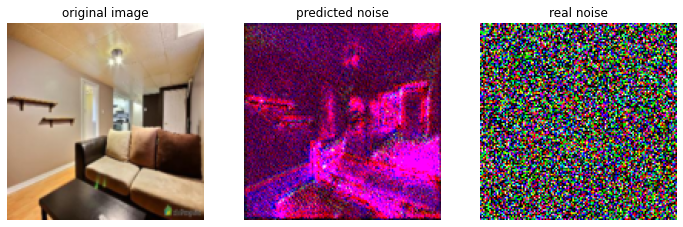

In [11]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
ax[0].imshow(v2.Resize((config.image_size, config.image_size))(real_img))
ax[1].imshow(noise_pred[0].detach().cpu().permute(1,2,0))
ax[2].imshow(noise[0].detach().cpu().permute(1,2,0))
ax[1].set_title('predicted noise')
ax[2].set_title('real noise')
ax[0].set_title('original image')
for axes in ax:
    axes.axis('off')
plt.savefig("../report/media/denoising.png", dpi = 200)
plt.show()

# training loop, evaluation

In [ ]:
def evaluate(epoch, pipeline, test_dir, random_seed = 69420):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=16,
        generator=torch.manual_seed(random_seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images to disk
    
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [15]:
def process_batch(batch):
    return batch['image'].to(device)

train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [17]:
from accelerate import Accelerator
# from tqdm.auto import tqdm
from pathlib import Path

from torch.cuda.amp import autocast, GradScaler
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
            os.makedirs(os.path.join(config.output_dir, "logs"), exist_ok=True)
        accelerator.init_trackers("train_example")
        

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for batch in tqdm(train_dataloader):
            clean_images = batch["image"].to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(epoch, pipeline, config.output_dir)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.output_dir is not None:
                    pipeline.save_pretrained(config.output_dir)

In [18]:
model = get_unetmodel()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [19]:
model.from_pretrained('../models/ddpm/size128_lr4/unet/', use_safetensors = True)
noise_scheduler.from_pretrained('../models/ddpm/size128_lr4/scheduler/')

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [20]:
noise_pred = model(noisy_image.to(device), timesteps.to(device)).sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


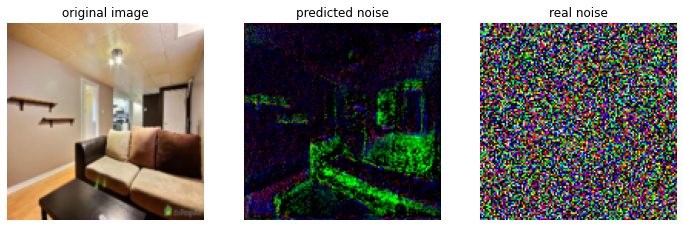

In [21]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
ax[0].imshow(v2.Resize((config.image_size, config.image_size))(real_img))
ax[1].imshow(noise_pred[0].detach().cpu().permute(1,2,0))
ax[2].imshow(noise[0].detach().cpu().permute(1,2,0))
ax[1].set_title('predicted noise')
ax[2].set_title('real noise')
ax[0].set_title('original image')
for axes in ax:
    axes.axis('off')
plt.savefig("../report/media/denoising_trained_a_bit.png", dpi = 200)
plt.show()

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

In [ ]:
dataset2 = load_dataset(
    '../data/data0/lsun/bedroom',
    data_dir='../data/data0/lsun/bedroom',
    split='train',
    trust_remote_code=True,
)
dataset2.set_transform(preprocess)
train_dataloader2 = DataLoader(dataset2, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
def train_loop2(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, start_epochs, stop_epochs, output_dir):


    # Now you train the model
    for epoch in range(start_epochs, stop_epochs+1):
        global_step = 0
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        
        for batch in tqdm(train_dataloader):
            clean_images = batch["image"].to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

                           # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            # accelerator.backward(loss)

            # accelerator.clip_grad_norm_(model.parameters(), 1.0)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            # accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

        os.makedirs(output_dir, exist_ok=True)
        if (epoch + 1) % 3 == 0 or epoch == stop_epochs - 1:
            evaluate(epoch, pipeline, output_dir)

        if (epoch + 1) % 1 == 0 or epoch == stop_epochs - 1:
            if config.output_dir is not None:
                pipeline.save_pretrained(output_dir)

In [12]:
model = get_unetmodel()
model.from_pretrained('../models/ddpm/size128_lr4/unet/', use_safetensors = True)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


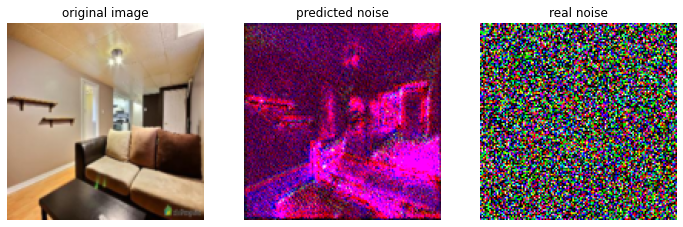

In [14]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
ax[0].imshow(v2.Resize((config.image_size, config.image_size))(real_img))
ax[1].imshow(noise_pred[0].detach().cpu().permute(1,2,0))
ax[2].imshow(noise[0].detach().cpu().permute(1,2,0))
ax[1].set_title('predicted noise')
ax[2].set_title('real noise')
ax[0].set_title('original image')
for axes in ax:
    axes.axis('off')
# plt.savefig("../report/media/denoising_trained_a_bit.png", dpi = 200)
plt.show()

In [15]:
noise_pred_trained = model(noisy_image.to(device), timesteps.to(device)).sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


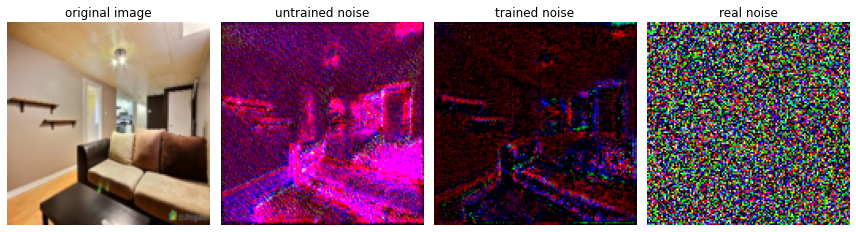

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
axes[0].imshow(v2.Resize((config.image_size, config.image_size))(real_img))
axes[1].imshow(noise_pred[0].detach().cpu().permute(1, 2, 0))
axes[3].imshow(noise[0].detach().cpu().permute(1, 2, 0))
axes[2].imshow(noise_pred_trained[0].detach().cpu().permute(1, 2, 0))
axes[0].set_title('original image')
axes[1].set_title('untrained noise')
axes[3].set_title('real noise')
axes[2].set_title('trained noise')
for ax in axes:
    ax.axis('off')
fig.tight_layout()
plt.savefig("../report/media/denoising_full.png", dpi = 200)
plt.show()

In [28]:
noise_pred[0].min(), noise_pred[0].max()

(tensor(-3.1369, grad_fn=<MinBackward1>),
 tensor(2.9924, grad_fn=<MaxBackward1>))

In [29]:
noise_pred_trained[0].min(), noise_pred_trained[0].max()

(tensor(-1.9267, grad_fn=<MinBackward1>),
 tensor(1.5589, grad_fn=<MaxBackward1>))

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)